<a href="https://colab.research.google.com/github/s2ul2/bitamin/blob/main/6%EC%A3%BC%EC%B0%A8_%EB%B3%B5%EC%8A%B5%EA%B3%BC%EC%A0%9C_%EB%AC%B8%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-(1). 워드 임베딩의 역할을 2가지 이상 서술하세요.

1. 단어, 문장 간 관련도 계산한다.
2. 의미적, 문법적 정보를 함축하고 있다.

# 1-(2). word2vec 모델이 학습이 완료된 후 가운데 은닉층은 어떠한 정보를 가지게 되는지, 그리고 어떤 방식으로 우리는 은닉층 정보를 활용할 수 있는지 아시는만큼 서술해주세요

# 1-(3). Word2Vec의 두 가지 모델인 CBOW와 Skip-gram의 차이점을 서술하고, 어떤 모델이 더 나은지 그 이유를 설명하세요.

1. CBOW : 입력값으로 여러개의 단어 사용, 학습을 위해 하나의 단어와 비교
2. Skip-gram : 입력값으로 하나의 단어 사용, 학습을 위해 주변의 여러 단어와 비교

--> Skip-gram 모델이 더 좋다. 
* 이유 : CBOW에 비해 중심 단어의 업데이트 기회가 많기 때문에

# 2. Word2Vec을 이용한 영어 텍스트 분류


영화 평점 데이터를 활용한 감성 분석(sentiment analysis)을 Word2Vec으로 진행해보겠습니다.


## 데이터 전처리 

데이터 불러오기

경로와 압축을 풀 파일명을 리스트로 선언한 후 반복문을 사용해 압축풀기

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
DATA_IN_PATH = '/content/drive/MyDrive/비타민/2학기/6week_WordEmbedding/복습과제/'

file_list = ['labeledTrainData.tsv.zip', 'testData.tsv.zip', 'unlabeledTrainData.tsv.zip']

for file in file_list:
  # 압축풀기 대상 설정 및 모드 설정
  zipRef = zipfile.ZipFile(DATA_IN_PATH + file, 'r')
  # 압축 풀기 및 저장 경로 설정
  zipRef.extractall(DATA_IN_PATH)
  # 호출 종료
  zipRef.close()

In [2]:
DATA_IN_PATH = '/content/drive/MyDrive/비타민/2학기/6week_WordEmbedding/복습과제/'

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프를 바로 그리도록 함
%matplotlib inline

In [4]:
train_data = pd.read_csv(DATA_IN_PATH+"labeledTrainData.tsv", header=0, delimiter='\t', quoting=3)
# 데이터는 tap(\t)으로 구분돼 있으므로 delimeter='\t', 각 데이터에 각 항목명(Header)이 포함돼 있기 때문에 header인자에 0을 설정해줍니다. 그리고 쌍따옴표를 무시하기 위해 quoting=3을 설정합니다.

train_data.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


### (1) 데이터 살펴보기

In [5]:
# 데이터 크기
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH):
  if 'tsv' in file and 'zip' not in file:
    print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

# 학습 데이터의 개수
print('전체 학습 데이터의 개수: {}'.format(len(train_data)))

파일 크기 : 
testData.tsv                  32.72MB
labeledTrainData.tsv          33.56MB
전체 학습 데이터의 개수: 25000


In [6]:
# 각 리뷰의 길이
train_length = train_data['review'].apply(len)
train_length.head()

0    2304
1     948
2    2451
3    2247
4    2233
Name: review, dtype: int64

=> 각 리뷰의 문자 길이가 대부분 6,000 이하이고 대부분 2,000이하에 분포돼 있음을 알 수 있고 일부 데이터의 경우 이상치로 10,000 이상의 값을 가지고 있다는 것을 알 수 있습니다.

Text(0, 0.5, 'Number of review')

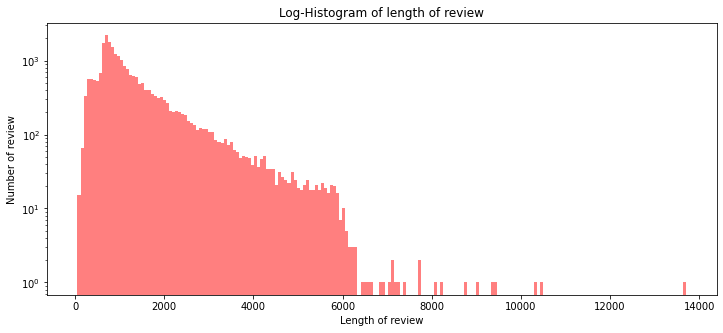

In [8]:
# 각 review의 길이에 대한 히스토그램
plt.figure(figsize=(12, 5))

plt.hist(train_length, bins=200, alpha=0.5, color='r', label='word')

# y축의 범위를 log단위로 바꿔주고 non-positive에 대해서는 아주작은 양수로 클리핑해줍니다.
plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of length of review')

plt.xlabel('Length of review')

plt.ylabel('Number of review')

In [9]:
# 기초 통계량 확인
train_length.describe()

count    25000.000000
mean      1329.710560
std       1005.239246
min         54.000000
25%        705.000000
50%        983.000000
75%       1619.000000
max      13710.000000
Name: review, dtype: float64

{'boxes': [<matplotlib.lines.Line2D at 0x7f3873b39c90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3873c91310>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3873b44910>],
 'means': [<matplotlib.lines.Line2D at 0x7f3873db0190>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3873b52250>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3873df9950>,
  <matplotlib.lines.Line2D at 0x7f3873e0f790>]}

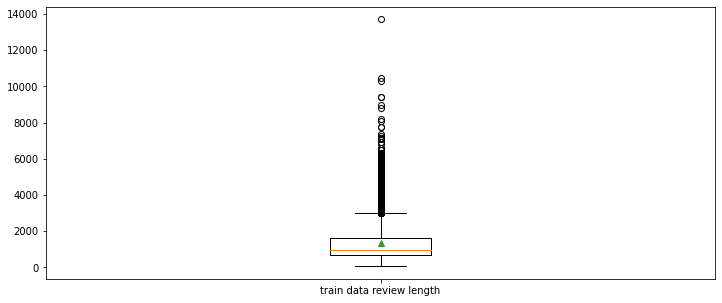

In [10]:
# 학습 데이터의 길이에 대한 boxplot
plt.figure(figsize=(12, 5))

plt.boxplot(train_length, labels=['train data review length'], showmeans=True)

워드 클라우드를 통한 빈도수 확인

In [11]:
!pip install wordcloud

(-0.5, 799.5, 599.5, -0.5)

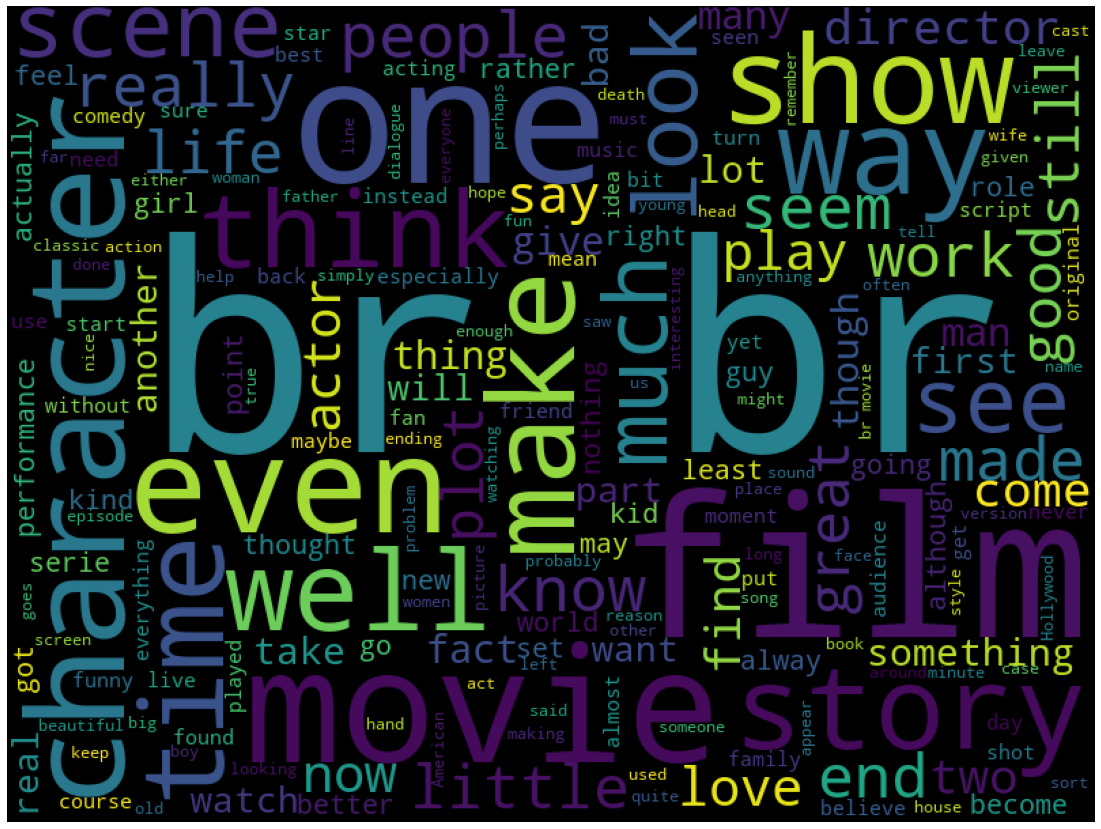

In [12]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(' '.join(train_data['review']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


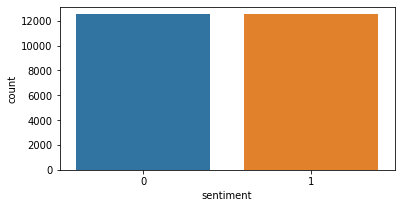

In [13]:
# label의 분포그래프
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['sentiment'])

In [14]:
print("긍정 리뷰 개수: {}".format(train_data['sentiment'].value_counts()[1]))
print("부정 리뷰 개수: {}".format(train_data['sentiment'].value_counts()[0]))

긍정 리뷰 개수: 12500
부정 리뷰 개수: 12500


In [15]:
# 띄어쓰기 기준으로 하나의 단어라 생각하고 개수를 계산하여 각 단어의 길이를 가지는 변수를 설정
train_word_counts = train_data['review'].apply(lambda x: len(x.split(' ')))

Text(0, 0.5, 'Number of reviews')

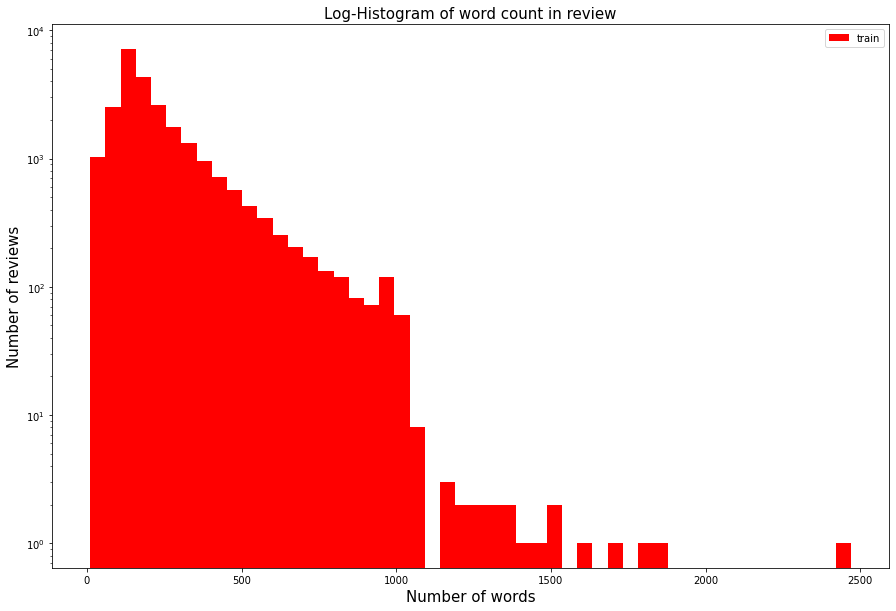

In [16]:
plt.figure(figsize=(15,10))
plt.hist(train_word_counts, bins=50, facecolor='r', label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

=> 대부분의 단어가 1000개 미만의 단어를 가지고 있고, 대부분 200개 정도의 단어를 가지고 있음을 확인할 수 있습니다.

In [17]:
train_word_counts.describe()

count    25000.000000
mean       233.786240
std        173.745845
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: review, dtype: float64

=> review의 75%가 300개 이하의 단어를 가지고 있음을 확인 할 수 있습니다.

각 review에 대해 구두점과 대소문자(추후 제거하게 될 학습에 방해가 되는 요소들) 비율 값을 확인

In [18]:
# 물음표가 구두점으로 사용되는 비율
qmarks = np.mean(train_data['review'].apply(lambda x : '?' in x))
# 마침표가 구두점으로 사용되는 비율
fullstop = np.mean(train_data['review'].apply(lambda x : '.' in x))
# 첫 번째 대문자의 비율
capital_first = np.mean(train_data['review'].apply(lambda x : x[0].isupper()))
# 대문자 비율
capitals = np.mean(train_data['review'].apply(lambda x : max([y.isupper() for y in x])))
# 숫자 비율
numbers = np.mean(train_data['review'].apply(lambda x : max([y.isdigit() for y in x])))

print('물음표가 있는 질문: {:.2f}%'.format(qmarks * 100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop * 100))
print('첫 글자가 대문자인 질문: {:.2f}%'.format(capital_first * 100))
print('대문자가 있는 질문: {:.2f}%'.format(capitals * 100))
print('숫자가 있는 질문: {:.2f}%'.format(numbers * 100))

물음표가 있는 질문: 29.55%
마침표가 있는 질문: 99.69%
첫 글자가 대문자인 질문: 0.00%
대문자가 있는 질문: 99.59%
숫자가 있는 질문: 56.66%


### (2) 데이터 전처리

In [19]:
import re # 데이터 정제
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup # 데이터 정제
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences # 데이터 전처리
from tensorflow.keras.preprocessing.text import Tokenizer # 데이터 전처리
import nltk
nltk.download('stopwords')  # 불용어 제거

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
# 데이터 전처리 함수 정의
def preprocessing(review, remove_stopwords=False):
  # 불용어 제거는 옵션으로 선택

  # 1. HTML 태그 제거
  review_text = BeautifulSoup(review, 'html5lib').get_text()

  # 2. 영어가 아닌 특수문자를 공백(" ")으로 대체
  review_text = re.sub("[^a-zA-Z]", " ", review_text)

  # 3. 대문자를 소문자로 바꾸고 공백 단위로 텍스트를 나눠서 리스트로 만든다.
  words = review_text.lower().split()

  if remove_stopwords:
    # 4. 불용어 제거

    # 영어 불용어 불러오기
    stops = set(stopwords.words('english'))

    # 불용어가 아닌 단어로 이뤄진 새로운 리스트 생성
    words = [w for w in words if not w in stops]

    # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.
    clean_review = ' '.join(words)

  else:
    # 불용어를 제거하지 않을 때
    clean_review = ' '.join(words)

  return clean_review

In [21]:
train_data['clean_review']=train_data['review'].apply(lambda x : preprocessing(review=x, remove_stopwords=True))

train_data['clean_review'][0]

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

In [22]:
# 각 단어를 인덱스로 벡터화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['clean_review'])
text_sequences = tokenizer.texts_to_sequences(train_data['clean_review'])

In [23]:
# 단어 사전
word_vocab = tokenizer.word_index
print(word_vocab)
print("전체 단어 개수:", len(word_vocab))

{'movie': 1, 'film': 2, 'one': 3, 'like': 4, 'good': 5, 'time': 6, 'even': 7, 'would': 8, 'story': 9, 'really': 10, 'see': 11, 'well': 12, 'much': 13, 'get': 14, 'bad': 15, 'people': 16, 'also': 17, 'first': 18, 'great': 19, 'made': 20, 'way': 21, 'make': 22, 'could': 23, 'movies': 24, 'think': 25, 'characters': 26, 'character': 27, 'watch': 28, 'two': 29, 'films': 30, 'seen': 31, 'many': 32, 'life': 33, 'plot': 34, 'acting': 35, 'never': 36, 'love': 37, 'little': 38, 'best': 39, 'show': 40, 'know': 41, 'ever': 42, 'man': 43, 'better': 44, 'end': 45, 'still': 46, 'say': 47, 'scene': 48, 'scenes': 49, 'go': 50, 'something': 51, 'back': 52, 'real': 53, 'watching': 54, 'though': 55, 'thing': 56, 'old': 57, 'years': 58, 'actors': 59, 'director': 60, 'work': 61, 'another': 62, 'new': 63, 'nothing': 64, 'funny': 65, 'actually': 66, 'makes': 67, 'look': 68, 'find': 69, 'going': 70, 'part': 71, 'lot': 72, 'every': 73, 'world': 74, 'cast': 75, 'us': 76, 'quite': 77, 'want': 78, 'things': 79, 'p

In [24]:
data_configs = {}

data_configs['vocab'] = word_vocab

data_configs['vocab_size'] = len(word_vocab) + 1

현재 각 데이터는 서로 길이가 다른데 이 길이를 하나로 통일해야 이후 모델에 바로 적용할 수 있기 때문에 특정 길이를 최대 길이로 정하고 더 긴 데이터의 경우 뒷부분을 자르고 짧은 데이터의 경우에는 0 값으로 패딩하는 작업을 진행해줍니다.

패딩 처리에는 앞서 불러온 pad_sequences 함수를 사용합니다. 이 함수를 사용할 때는 인자로 패딩을 적용할 데이터, 최대 길이값, 0 값을 데이터 앞에 넣을지 뒤에 넣을 지 여부를 설정합니다. 또한, 제일 마지막 단어부터 단어를 카운트한다는 것에 유의해야 합니다. 여기서 최대 길이를 174로 설정했는데, 이는 앞서 데이터 분석 과정에서 단어 개수의 통계를 계산했을 때 나왔던 중앙값(median)입니다. 보통 평균이 아닌 중앙값(median)을 사용하는 경우가 많은데, 평균은 이상치에 민감하기 때문입니다.


In [25]:
# 문장 최대 길이
MAX_SEQUENCE_LENGTH = 174

# padding을 뒷부분에 해줍니다.
train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print('Shape of train data: ', train_inputs.shape)

Shape of train data:  (25000, 174)


이후 전처리한 데이터를 저장할 때 넘파이 형태로 저장할 것이므로 학습 시 label 값을 넘파이 배열로 저장합니다.

In [26]:
train_labels = np.array(train_data['sentiment'])
print('Shape of label tensor: ', train_labels.shape)

Shape of label tensor:  (25000,)


전처리한 데이터를 이후 모델링 과정에서 사용하기 위해 저장해줍니다.

In [27]:
DATA_OUT_PATH = '/content/drive/MyDrive/비타민/2학기/6week_WordEmbedding/복습과제/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TRAIN_CLEAN_DATA = 'train_clean.csv'
DATA_CONFIGS = 'data_configs.json'

import os
# 저장하는 디렉터리가 존재하지 않으면 생성
if not os.path.exists(DATA_OUT_PATH):
  os.makedirs(DATA_IN_PATH)

# 전처리된 데이터를 numpy 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)

# 정제된 텍스트를 CSV 형태로 저장
train_data.to_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA, index=False)

# 데이터 사전을 JSON 형태로 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)

In [28]:
test_data = pd.read_csv(DATA_IN_PATH + 'testData.tsv', header=0, delimiter='\t', quoting=3)

test_data['review'] = test_data['review'].apply(lambda x: preprocessing(x, True))
test_id = np.array(test_data['id'])

text_sequences = tokenizer.texts_to_sequences(test_data['review'])
test_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [29]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_CLEAN_DATA = 'test_clean.csv'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)
test_data.to_csv(DATA_IN_PATH + TEST_CLEAN_DATA, index=False)

## Woed2vec(CBOW)을 활용한 모델 구현

word2vec의 경우 단어로 표현된 리스트를 입력값으로 넣어야 하기 때문에 전처리한 넘파이 배열을 바로 사용하지 않습니다. 따라서 전처리된 텍스트 데이터를 불러온 후 각 단어들의 리스트로 나눠야 합니다.

In [30]:
DATA_IN_PATH = '/content/drive/MyDrive/비타민/2학기/6week_WordEmbedding/복습과제/'

TRAIN_CLEAN_DATA = 'train_clean.csv'

train_data = pd.read_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA)

reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])

sentences = []
for review in reviews:
  sentences.append(review.split())

### (1)word2vec 벡터화

★★★문제★★★  
아래의 파라미터를 조절해서 성능을 올려주세요!  
down sampling은 건드리지 않아 주셔도 됩니다  
--> negative sampling과 sub sampling에 대한 개념 이해 필요

In [37]:
# num_features : 각 단어에 대해 임베딩된 벡터의 차원을 정한다.
# min_word_count : 모델에 의미 있는 단어를 가지고 학습하기 위해 적은 빈도 수의 단어들은 학습 하지 않기 위해 최소 빈도수를 설정한다.
# num_workers : 모델 학습 시 학습을 위한 프로세스 개수를 지정한다.
# context : word2vec을 수행하기 위한 context 윈도우 크기를 지정한다.
# downsampling : word2vec 학습을 수행할 때 빠른 학습을 위해 정답 단어 label에 대한 downsampling 비율을 지정한다. 
#                 보통 0.001이 좋은 성능을 낸다고 한다.

# sg의 default값인 0을 사용했으므로 Word2vec의 CBOW모델 사용
num_features = 300
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

In [38]:
!pip install gensim

In [39]:
# word2vec을 학습하는 과정에서 진행 상황을 확인해 보기 위해 다음과 같이 logging을 통해 확인해 볼 수 있습니다.
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [40]:
from gensim.models import word2vec
print("Training model ....")

model = word2vec.Word2Vec(sentences,
                        workers=num_workers,
                        size=num_features,
                        min_count=min_word_count,
                        window=context,
                        sample=downsampling)

2022-04-03 08:36:58,794 : INFO : collecting all words and their counts
2022-04-03 08:36:58,797 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Training model ....


2022-04-03 08:36:59,431 : INFO : PROGRESS: at sentence #10000, processed 2354780 words, keeping 163178 word types
2022-04-03 08:37:00,186 : INFO : PROGRESS: at sentence #20000, processed 4686268 words, keeping 251892 word types
2022-04-03 08:37:00,493 : INFO : collected 289705 word types from a corpus of 5844706 raw words and 25000 sentences
2022-04-03 08:37:00,494 : INFO : Loading a fresh vocabulary
2022-04-03 08:37:00,641 : INFO : effective_min_count=40 retains 9563 unique words (3% of original 289705, drops 280142)
2022-04-03 08:37:00,642 : INFO : effective_min_count=40 leaves 5008901 word corpus (85% of original 5844706, drops 835805)
2022-04-03 08:37:00,684 : INFO : deleting the raw counts dictionary of 289705 items
2022-04-03 08:37:00,693 : INFO : sample=0.001 downsamples 45 most-common words
2022-04-03 08:37:00,698 : INFO : downsampling leaves estimated 3711134 word corpus (74.1% of prior 5008901)
2022-04-03 08:37:00,734 : INFO : estimated required memory for 9563 words and 300 

In [41]:
# 모델 저장하기
model_name = "300features_40minwords_10context"
model.save(model_name)

2022-04-03 08:38:24,543 : INFO : saving Word2Vec object under 300features_40minwords_10context, separately None
2022-04-03 08:38:24,544 : INFO : not storing attribute vectors_norm
2022-04-03 08:38:24,546 : INFO : not storing attribute cum_table
2022-04-03 08:38:24,818 : INFO : saved 300features_40minwords_10context


### (2) word2vec 모델을 활용하여 선형 회귀 모델 학습

우선 학습을 하기 위해서는 하나의 review를 같은 형태의 입력값으로 만들어야 합니. 지금은 word2vec 모델에서 각 단어가 벡터로 표현되어 있습니다. 그리고 review 마다 단어의 개수가 모두 다르기 때문에 입력값을 하나의 형태로 만들어야 합니다.

아래 model을 통해 얻은 단어 하나의 feature는 (300,)의 shape를 갖게 될 것입니다.

가장 단순한 방법은 문장에 있는 모든 단어의 벡터값에 대해 평균을 내서 리뷰 하나당 하나의 벡터로 만드는 방법이 있습니다.

- words : 단어의 모음인 하나의 review
- model : 학습한 word2vec 모델
- num_features : word2vec으로 임베딩할 때 정했던 벡터의 차원 수

In [42]:
# 하나의 리뷰에 대해 전체 단어의 평균값을 계산하는 함수 정의

# words : 단어의 모음인 하나의 리뷰가 들어간다.
# model : word2vec 모델을 넣는 공이며, 우리가 학습한 word2vec 모델이 들어간다.
# num_features : word2vec으로 임베딩할 때 정했던 벡터의 차원 수를 뜻한다.

def get_features(words, model, num_features):
  # 출력 벡터 초기화
  feature_vector = np.zeros((num_features), dtype=np.float32)

  num_words = 0
  # 어휘사전 준비
  index2word_set = set(model.wv.index2word)

  for w in words:
    if w in index2word_set:
      num_words +=1
      # 사전에 해당하는 단어에 대해 단어 벡터를 더함
      feature_vector = np.add(feature_vector, model[w])

  # 문장의 단어 수만큼 나누어 단어 벡터의 평균값을 문장 벡터로 함
  feature_vector = np.divide(feature_vector, num_words)
  return feature_vector

In [43]:
# 전체 리뷰에 대해 각 리뷰의 평균 벡터를 구하는 함수 정의

# reviews : 학습 데이터인 전체 리뷰 데이터를 입력
# model : word2vec 모델을 입력
# num_features : word2vec으로 임베딩할 때 정했던 벡터의 차원 수

def get_dataset(reviews, model, num_features):
  dataset = list()

  for s in reviews:
    dataset.append(get_features(s, model, num_features))

  reviewFeatureVecs = np.stack(dataset)

  return reviewFeatureVecs

In [44]:
# 구현한 함수를 사용해 실제 학습에 사용될 입력값을 만듭니다.
test_data_vecs = get_dataset(sentences, model, num_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


### (3) 학습 데이터와 검증 데이터 셋 분리

In [45]:
from sklearn.model_selection import train_test_split
import numpy as np

X = test_data_vecs
y = np.array(sentiments)

RANDOM_SEED = 42
TEST_SPLIT = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, 
                                                    random_state=RANDOM_SEED)

### (4) 모델 선언 및 학습

저희는 가장 기본적인 logistic regression을 이용했지만
random forest, lightgbm, xgboost 등 
다양한 분류 모델을 이용해 성능을 올려보세요!

(자유롭게 과제를 해주시면 됩니다)

In [46]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight='balanced') 
# 각 라벨에 대해 균형있게 학습하기 위해 class_weight를 balanced로 설정합니다.
lgs.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight='balanced')

### (5) 검증 데이터셋을 이용한 성능 평가

In [47]:
predicted = lgs.predict(X_test)
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test, (lgs.predict_proba(X_test)[:, 1]))
auc = metrics.auc(fpr, tpr)

print("------------")
print("Accuracy: %f" % lgs.score(X_test, y_test))  #checking the accuracy
print("Precision: %f" % metrics.precision_score(y_test, predicted))
print("Recall: %f" % metrics.recall_score(y_test, predicted))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
print("AUC: %f" % auc)

------------
Accuracy: 0.831600
Precision: 0.823371
Recall: 0.847559
F1-Score: 0.835290
AUC: 0.906897


# 3-(1). Word2Vec와 비교했을 때 Fast Text가 갖는 장점에 대해 서술하세요.

Word2Vec는 단어를 쪼개질 수 없는 단위로 생각한다면, FastText는 하나의 단어 안에도 여러 단어들 즉 subword를 고려하여 학습한다는 장점이 있다.

# 3-(2). 사전학습된 임베딩을 사용하는 이유를 서술하세요.

데이터가 부족할 경우 임베딩 학습이 충분히 이뤄지지 않을 수 있으므로 성능이 검증된 사전 학습된 임베딩을 사용한다.

# 3-(3). Fine-tuning에서 learning rate의 크기를 작게 설정하는 이유에 대해 서술하세요.

# 4. Fast Text를 이용한 한국어 뉴스 토픽 분류

In [2]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Users\tyumi\Downloads"
from konlpy.tag import *  #한국어 형태소 분석
okt=Okt()
!pip3 install fasttext  #fasttext 설치
import fasttext
import pandas as pd 
import re  #정규표현식
from tqdm import tqdm_notebook
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [80.8 kB]
Get:13 http://archive.ubuntu.com/ubun

In [6]:
data_path = '/content/drive/MyDrive/비타민/2학기/6week_WordEmbedding/복습과제'

In [7]:
test=pd.read_csv(data_path + '/test_data.csv')
train=pd.read_csv(data_path + '/train_data.csv')
sample_sub=pd.read_csv(data_path + '/sample_submission.csv')
topic_dict=pd.read_csv(data_path + '/topic_dict.csv')

In [8]:
train.head()  # train data 확인

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [9]:
topic_dict  # 기사 주제에 대한 설명

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [10]:
# 정규표현식을 이용하여 train, test data의 title에서 한글을 제외한 나머지 제거

t_list=[]
for t in range(len(train['title'])):
  train['title'][t]=' '.join(re.compile('[가-힣]+').findall(train['title'][t]))

t_list=[]
for t in range(len(test['title'])):
  test['title'][t]=' '.join(re.compile('[가-힣]+').findall(test['title'][t]))


# okt를 이용하여 train, test data의 title에서 명사만 추출

for i in range(len(train)):
  train['title'][i]=okt.nouns(train['title'][i])

for i in range(len(test)):
  test['title'][i]=okt.nouns(test['title'][i])

data_train = train['title']
data_test = test['title']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages

In [11]:
# Fast Text 모델의 입력값 형태로 만들기 위해 데이터를 메모장 파일로 저장

with open(data_path + '/data_train.txt', "w") as f:
  for i in range(len(data_train)):
    f.write(' '.join(data_train.iloc[i])+'\n')
  f.close()

with open(data_path + '/data_test.txt', "w") as f:
  for i in range(len(data_test)):
    f.write(' '.join(data_test.iloc[i])+'\n')
  f.close()

In [12]:
# Fast Text 훈련 - Skipgram

model = fasttext.train_unsupervised(input= data_path + '/data_train.txt',model = 'skipgram', lr = 0.05,
dim = 100, ws = 5, epoch = 50,
minn = 1, word_ngrams = 6)

★★★코드 채우기★★★

In [13]:
# 정수 인덱싱 과정
tokenizer = Tokenizer()  # data_train과 data_test에 있는 고유한 단어에 번호 할당
tokenizer.fit_on_texts(data_train)
vocab_size=len(tokenizer.word_index)+1
data_train = tokenizer.texts_to_sequences(data_train)
data_test = tokenizer.texts_to_sequences(data_test) 

# data_train의 모든 문장 중 가장 긴 단어 길이 구하기

max_len = 0
for row in data_train:
    if len(row) > max_len:
        max_len = len(row)

# max_len에 맞춰서 패딩하기
X_train = pad_sequences(data_train, maxlen = max_len)
X_test = pad_sequences(data_test, maxlen = max_len)

In [14]:
# 임베딩 행렬 구하기
dd=list(tokenizer.word_index.keys())
embedding_matrix=[np.zeros(shape=(100,),dtype=float)]
for i in range(len(dd)):
  embedding_matrix.append(model.get_word_vector(dd[i]))  # Fast Text로 data_train을 구성하는 각 단어의 벡터를 embeddig_matrix에 추가
embedding_matrix=np.array(embedding_matrix)

In [15]:
target = pd.get_dummies(train['topic_idx']).values

x_train=X_train
x_test=X_test
y_train=target

★★★코드 채우기★★★  

In [16]:
# 모델 구축

max_len=15
vocab_size=24418
embedding_dim=100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True))  # Embedding 레이어 완성하기
model.add(LSTM(100))
model.add(Dense(7, activation='softmax'))  # 출력층 함수 설정하기

In [17]:
import time
start = time.time()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1000)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], validation_data=(X_valid,y_valid),batch_size=60, validation_split=0.2)
print("skipgram 실행시간 :", time.time() - start)

Epoch 1/10
487/487 [==============================] - ETA: 0s - loss: 1.6966 - acc: 0.4603
Epoch 1: val_acc improved from -inf to 0.62984, saving model to best_model.h5
487/487 [==============================] - 11s 10ms/step - loss: 1.6966 - acc: 0.4603 - val_loss: 1.4241 - val_acc: 0.6298
Epoch 2/10
486/487 [============================>.] - ETA: 0s - loss: 1.1588 - acc: 0.6982
Epoch 2: val_acc improved from 0.62984 to 0.74209, saving model to best_model.h5
487/487 [==============================] - 4s 9ms/step - loss: 1.1579 - acc: 0.6985 - val_loss: 0.9211 - val_acc: 0.7421
Epoch 3/10
485/487 [============================>.] - ETA: 0s - loss: 0.8010 - acc: 0.7646
Epoch 3: val_acc improved from 0.74209 to 0.77755, saving model to best_model.h5
487/487 [==============================] - 4s 9ms/step - loss: 0.8008 - acc: 0.7645 - val_loss: 0.6991 - val_acc: 0.7775
Epoch 4/10
483/487 [============================>.] - ETA: 0s - loss: 0.6529 - acc: 0.7886
Epoch 4: val_acc improved from 

In [18]:
# Fast Text 훈련 - CBOW

model = fasttext.train_unsupervised(input=data_path + '/data_train.txt',model = 'cbow', lr = 0.05,
dim = 100, ws = 5, epoch = 50,
minn = 1, word_ngrams = 6)

In [19]:
# 임베딩 행렬 구하기
dd=list(tokenizer.word_index.keys())
embedding_matrix=[np.zeros(shape=(100,),dtype=float)]
for i in range(len(dd)):
  embedding_matrix.append(model.get_word_vector(dd[i]))  # Fast Text로 data_train을 구성하는 각 단어의 벡터를 embeddig_matrix에 추가
embedding_matrix=np.array(embedding_matrix)

★★★코드 채우기★★★  

In [20]:
# 모델 구축

max_len=15
vocab_size=24418
embedding_dim=100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim,  weights=[embedding_matrix], trainable=True))  # Embedding 레이어 완성하기
model.add(LSTM(100))
model.add(Dense(7, activation='softmax'))  # 출력층 함수 설정하기

In [21]:
import time
start = time.time()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1000)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], validation_data=(X_valid,y_valid),batch_size=60, validation_split=0.2)
print("cbow 실행시간 :", time.time() - start)

Epoch 1/10
386/390 [============================>.] - ETA: 0s - loss: 1.6273 - acc: 0.4508
Epoch 1: val_acc improved from -inf to 0.62047, saving model to best_model.h5
390/390 [==============================] - 8s 16ms/step - loss: 1.6244 - acc: 0.4522 - val_loss: 1.3377 - val_acc: 0.6205
Epoch 2/10
386/390 [============================>.] - ETA: 0s - loss: 1.1593 - acc: 0.6611
Epoch 2: val_acc improved from 0.62047 to 0.69713, saving model to best_model.h5
390/390 [==============================] - 5s 12ms/step - loss: 1.1584 - acc: 0.6613 - val_loss: 1.0214 - val_acc: 0.6971
Epoch 3/10
386/390 [============================>.] - ETA: 0s - loss: 0.9259 - acc: 0.7116
Epoch 3: val_acc improved from 0.69713 to 0.73289, saving model to best_model.h5
390/390 [==============================] - 5s 13ms/step - loss: 0.9248 - acc: 0.7119 - val_loss: 0.8506 - val_acc: 0.7329
Epoch 4/10
390/390 [==============================] - ETA: 0s - loss: 0.7917 - acc: 0.7424
Epoch 4: val_acc improved from

# 4-(1). Skipgram과 CBOW를 이용한 모델들의 성능과 소요시간을 비교하세요. 두 지표에 차이가 있다면 차이가 발생한 이유를 생각하여 서술해주세요.

성능과 소요시간 면에서 skipgram과 CBOW를 비교했을 때 Skipgram이 우수하다.

[추가 자료] GloVe 손실함수 유도 과정  
https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/04/09/glove/